In [1]:
%pylab inline
from collections import namedtuple

import torch
from torchvision import models

import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torchvision import datasets
from torchvision import transforms
import torch.onnx


from PIL import Image
from collections import namedtuple
from torchvision import models

from itertools import chain
from datetime import datetime
 
import numpy as np
import pandas as pd

from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.onnx
from torch import nn
import torch.nn.functional as F
from torch import optim

from IPython import display
from IPython.display import Image as image_display

Populating the interactive namespace from numpy and matplotlib


In [2]:
class ResidualDense(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(ResidualDense, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, hidden_channels, kernel_size = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_channels, in_channels, kernel_size = 1),
            torch.nn.ReLU()
        )
    
    def forward(self, X):
        return X - self.model(X)

class ConditionerNet(torch.nn.Module):
    def __init__(self):
        super(ConditionerNet, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(4, 1000, kernel_size = 1),
            torch.nn.ReLU(),
            ResidualDense(1000, 1000),
            ResidualDense(1000, 1000),
            ResidualDense(1000, 1000),
            ResidualDense(1000, 1000),
            torch.nn.Conv2d(1000, 4224, kernel_size = 1)
        )
    
    def forward(self, X):
        return self.model(X)


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.conv1 = ConvLayer(3, 32, kernel_size = 9, stride = 1) 
        self.in1 = ContitionalInstanceNorm2d()

        self.conv2 = ConvLayer(32, 64, kernel_size = 3, stride = 2)
        self.in2 = ContitionalInstanceNorm2d()

        self.conv3 = ConvLayer(64, 128, kernel_size = 3, stride = 2)
        self.in3 = ContitionalInstanceNorm2d()

        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        self.res6 = ResidualBlock(128)
        self.res7 = ResidualBlock(128)

        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size = 3, stride = 1, upsample = 2)
        self.in4 = ContitionalInstanceNorm2d()
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size = 3, stride = 1, upsample = 2)
        self.in5 = ContitionalInstanceNorm2d()
        self.deconv3 = ConvLayer(32, 3, kernel_size = 9, stride = 1)
        self.relu = torch.nn.ReLU()

    def forward(self, X, gammas, betas):
        y = self.relu(self.in1(self.conv1(X), gammas[:,0:32,:,:], betas[:,0:32,:,:]))
        y = self.relu(self.in2(self.conv2(y), gammas[:,32:96,:,:], betas[:,32:96,:,:]))
        y = self.relu(self.in3(self.conv3(y), gammas[:,96:224,:,:], betas[:,96:224,:,:]))
        y = self.res1(y, gammas[:,224:480,:,:], betas[:,224:480,:,:])
        y = self.res2(y, gammas[:,480:736,:,:], betas[:,480:736,:,:])
        y = self.res3(y, gammas[:,736:992,:,:], betas[:,736:992,:,:])
        y = self.res4(y, gammas[:,992:1248,:,:], betas[:,992:1248,:,:])
        y = self.res5(y, gammas[:,1248:1504,:,:], betas[:,1248:1504,:,:])
        y = self.res6(y, gammas[:,1600:1856,:,:], betas[:,1600:1856,:,:])
        y = self.res7(y, gammas[:,1856:2112,:,:], betas[:,1856:2112,:,:])
        y = self.relu(self.in4(self.deconv1(y), gammas[:,1504:1568,:,:], betas[:,1504:1568,:,:]))
        y = self.relu(self.in5(self.deconv2(y), gammas[:,1568:1600,:,:], betas[:,1568:1600,:,:]))
        y = self.deconv3(y) 
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = ContitionalInstanceNorm2d()
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = ContitionalInstanceNorm2d()
        self.relu = torch.nn.ReLU()

    def forward(self, x, gammas, betas):
        residual = x
        out = self.relu(self.in1(self.conv1(x), gammas[:,0:self.channels,:,:], betas[:,0:self.channels,:,:]))
        out = self.in2(self.conv2(out), gammas[:,self.channels:self.channels * 2,:,:], betas[:,self.channels:self.channels * 2,:,:])
        out = out + residual # need relu right after
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

class ContitionalInstanceNorm2d(torch.nn.Module):
    def __init__(self):
        super(ContitionalInstanceNorm2d, self).__init__()
    
    def forward(self, x, gammas, betas):
        std = x.std(dim = [2, 3], keepdim=True)
        mean = x.mean(dim = [2, 3], keepdim=True)

        l = (x - mean) / std

        return l * gammas + betas

In [3]:
def check_paths(args):
    try:
        if not os.path.exists(args.save_model_dir):
            os.makedirs(args.save_model_dir)
        if args.checkpoint_model_dir is not None and not (os.path.exists(args.checkpoint_model_dir)):
            os.makedirs(args.checkpoint_model_dir)
    except OSError as e:
        print(e)
        sys.exit(1)

def load_weights(args, conditioner, transformer):
    if args.model is not None:
        state_dict = torch.load(args.model)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        transformer.load_state_dict(state_dict)

        csd = torch.load(args.model+'.cond.pth')
        conditioner.load_state_dict(csd)        

#py

In [4]:
import torch
from PIL import Image


def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img


def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)


def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std



#VGG

In [5]:
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(9):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 18):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(18, 27):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(27, 36):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu2_2 = h
        h = self.slice2(h)
        h_relu3_4 = h
        h = self.slice3(h)
        h_relu4_4 = h
        h = self.slice4(h)
        h_relu5_4 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu2_2, h_relu3_4, h_relu4_4, h_relu5_4)
        return out

In [6]:
def train(args):
    device = torch.device("cuda:0" if args.cuda else "cpu")
    ALPHAS = [0, 0.5, 1]

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size)

    conditioner = ConditionerNet().to(device)
    transformer = TransformerNet().to(device)
    load_weights(args, conditioner, transformer)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg19(requires_grad=False).to(device)
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = load_image(args.style_image, size=args.style_size)
    style = style_transform(style)
    style = style.repeat(args.batch_size, 1, 1, 1).to(device)

    features_style = vgg(normalize_batch(style))
    gram_style = [gram_matrix(y) for y in features_style]
    loss_ema = torch.ones(4).to(device)
    layer_loss = torch.ones(4).to(device)
    ema_alpha = 0.01

    # For output stylized image during training
    fig = plt.figure(figsize=[30,20])
    gs = fig.add_gridspec(2, len(ALPHAS))
    main_ax = fig.add_subplot(gs[0, :])
    axes=[]
    for i in range(3):
        axes.append(fig.add_subplot(gs[1, i]))
    plt.tight_layout()
    content_losses = []
    style_losses = []
    total_losses = []
    counts = []

    for e in range(args.epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            if batch_id == 0:
                sample_content = x
                continue
            n_batch = len(x)
            count += n_batch
            counts.append(count)
            optimizer.zero_grad()

            x = x.to(device)

            if (torch.rand(1).item() > 0.5):
                stylization_vector = torch.rand(4).to(device)
            else:
                stylization_vector = torch.zeros(4).to(device)
                stylization_vector[batch_id % 4] = 1

            c_values = conditioner(
                torch.ones(n_batch, 4, 1, 1).to(device) * stylization_vector.unsqueeze(0).unsqueeze(2).unsqueeze(2))

            gammas = c_values[:, 0:2112, :, :]
            betas = c_values[:, 2112:4224, :, :]

            y = transformer(x, gammas, betas)

            y = normalize_batch(y)
            x = normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for i, (ft_y, gm_s) in enumerate(zip(features_y, gram_style)):
                gm_y = gram_matrix(ft_y)
                ll = mse_loss(gm_y, gm_s[:n_batch, :, :]) * args.style_weight
                style_loss += (loss_ema.sum() / loss_ema[i]) * ll * stylization_vector[i]
                layer_loss[i] = ll.detach()

            loss_ema = ema_alpha * layer_loss + (1 - ema_alpha) * loss_ema

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += loss_ema.sum()

            content_losses.append(content_loss.item())
            style_losses.append(loss_ema.sum())
            total_losses.append(loss_ema.sum() + content_loss.item())

            if (batch_id + 1) % args.log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                # print(mesg)

            if(batch_id + 1) % args.log_interval == 0:
                message = f"{datetime.now().strftime('%x %X')}  epoch {e}  [{count:>5d}/{len(train_dataset)}]"

                main_ax.clear()
                for i in range(len(ALPHAS)):
                    axes[i].clear()
                main_ax.set_title(message)
                start = len(style_losses)-150
                main_ax.plot(counts[start:], content_losses[start:], color='r', label='content')
                main_ax.plot(counts[start:], style_losses[start:], color='g', label='style')
                main_ax.plot(counts[start:], total_losses[start:], color='b', label='total')
                main_ax.legend(loc='upper right')
                main_ax.grid()

                stylization_vectors = [torch.tensor([0., 0., 0., 0]), torch.tensor([0., 1., 0, 0]), torch.tensor([1., 1., 1., 1])]
                with torch.no_grad():
                    result_images = []
                    for stylization_vector in stylization_vectors:
                        c_values = conditioner(stylization_vector.to(device).unsqueeze(0).unsqueeze(2).unsqueeze(2))
                        gammas = c_values[:, 0:2112, :, :]
                        betas = c_values[:, 2112:4224, :, :]
                        result = transformer(sample_content.to(device), gammas.to(device), betas.to(device)).to(device)

                        img = result[0].clone().clamp(0, 255).cpu().numpy()
                        img = img.transpose(1, 2, 0).astype("uint8")
                        img = Image.fromarray(img)
                        result_images.append(img)
                    for num, result_img in enumerate(result_images):
                        axes[num].imshow(result_img)
                        axes[num].axis('off');
                    display.display(fig)
                    display.clear_output(wait=True)
            
            # Checkpoint: save model and loss plots
            if args.save_dir is not None and (batch_id + 1) % args.checkpoint_interval == 0:
                # Save models' weights
                transformer.eval().cpu()
                conditioner.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
                ckpt_model_path = os.path.join(args.save_dir, ckpt_model_filename)
                torch.save(transformer.state_dict(), ckpt_model_path)
                torch.save(conditioner.state_dict(), ckpt_model_path+'.cond.pth')
                transformer.to(device).train()
                conditioner.to(device).train()
                

    # save model
    transformer.eval().cpu()
    save_model_filename = "epoch_" + str(args.epochs) + "_" + str(time.ctime()).replace(' ', '_').replace(':', '_') + "_" + str(
        args.content_weight) + "_" + str(args.style_weight) + ".model"
    save_model_path = os.path.join(args.save_dir, save_model_filename)
    torch.save(conditioner.state_dict(), save_model_path+'.cond.pth')
    torch.save(transformer.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)

In [7]:
def main():
    main_arg_parser = argparse.ArgumentParser(description="parser for fast-neural-style")
    subparsers = main_arg_parser.add_subparsers(title="subcommands", dest="subcommand")

    train_arg_parser = subparsers.add_parser("train", help="parser for training arguments")
    train_arg_parser.add_argument("--epochs", type=int, default=2,
                                  help="number of training epochs, default is 2")
    train_arg_parser.add_argument("--batch-size", type=int, default=4,
                                  help="batch size for training, default is 4")
    train_arg_parser.add_argument("--dataset", type=str, required=True,
                                  help="path to training dataset, the path should point to a folder "
                                       "containing another folder with all the training images")
    train_arg_parser.add_argument("--style-image", type=str, default="images/style-images/mosaic.jpg",
                                  help="path to style-image")
    train_arg_parser.add_argument("--save-model-dir", type=str, required=True,
                                  help="path to folder where trained model will be saved.")
    train_arg_parser.add_argument("--checkpoint-model-dir", type=str, default=None,
                                  help="path to folder where checkpoints of trained models will be saved")
    train_arg_parser.add_argument("--image-size", type=int, default=256,
                                  help="size of training images, default is 256 X 256")
    train_arg_parser.add_argument("--style-size", type=int, default=None,
                                  help="size of style-image, default is the original size of style image")
    train_arg_parser.add_argument("--cuda", type=int, required=True,
                                  help="set it to 1 for running on GPU, 0 for CPU")
    train_arg_parser.add_argument("--seed", type=int, default=42,
                                  help="random seed for training")
    train_arg_parser.add_argument("--content-weight", type=float, default=1e5,
                                  help="weight for content-loss, default is 1e5")
    train_arg_parser.add_argument("--style-weight", type=float, default=1e10,
                                  help="weight for style-loss, default is 1e10")
    train_arg_parser.add_argument("--lr", type=float, default=1e-3,
                                  help="learning rate, default is 1e-3")
    train_arg_parser.add_argument("--log-interval", type=int, default=500,
                                  help="number of images after which the training loss is logged, default is 500")
    train_arg_parser.add_argument("--checkpoint-interval", type=int, default=2000,
                                  help="number of batches after which a checkpoint of the trained model will be created")
    train_arg_parser.add_argument("--model", type=str, default=None, help="saved model")

    eval_arg_parser = subparsers.add_parser("eval", help="parser for evaluation/stylizing arguments")
    eval_arg_parser.add_argument("--content-image", type=str, required=True,
                                 help="path to content image you want to stylize")
    eval_arg_parser.add_argument("--content-scale", type=float, default=None,
                                 help="factor for scaling down the content image")
    eval_arg_parser.add_argument("--output-image", type=str, required=True,
                                 help="path for saving the output image")
    eval_arg_parser.add_argument("--model", type=str, required=True,
                                 help="saved model to be used for stylizing the image. If file ends in .pth - PyTorch path is used, if in .onnx - Caffe2 path")
    eval_arg_parser.add_argument("--animate", type=int, default=0,
                                 help="set it to 1 to export an animated set of frames, 0 for single frame export")
    eval_arg_parser.add_argument("--cuda", type=int, required=True,
                                 help="set it to 1 for running on GPU, 0 for CPU")
    eval_arg_parser.add_argument("--export_onnx", type=str,
                                 help="export ONNX model to a given file")

    args = main_arg_parser.parse_args()

    if args.subcommand is None:
        print("ERROR: specify either train or eval")
        sys.exit(1)
    if args.cuda and not torch.cuda.is_available():
        print("ERROR: cuda is not available, try running on CPU")
        sys.exit(1)

    if args.subcommand == "train":
        check_paths(args)
        train(args)
    else:
        stylize(args)

In [8]:
class Arguments:
    pass

args=Arguments()
args.cuda = True
args.learning_rate = 1e-3
args.model = None
args.models_dir = 'Models/'
args.model_name = 'diff_styles'   # trained model saved to args.save_model_dir+args.model_name+'.pth'. Also args.model_name affects name of checkpoint models. 
args.exp_weight = 0.01  # how much to exponentially average content and style loss time series
args.dataset = '/content/drive/MyDrive/cmc/stylization/MS_COCO' # take from https://cocodataset.org/#download. Any dataset of photo images works.
args.style_image = '/content/drive/MyDrive/cmc/stylization/styles/african_art.jpg'  # path to style-images directory (holding images of styles)
args.content_image = '/content/drive/MyDrive/cmc/stylization/content.jpg'
args.init_transformer_model = '' #Models/current4/checkpoint_images_100000/transformer.model #'Models/Save/my_model_orig.pth'
args.init_style_models_dir = '' #'/store/Datasets/Sample_Styles/'  # path to style-images directory (holding images of styles)
args.batch_size = 10   # take more, if GPU memory permits
args.epochs = 1       # number of training epochs (training over 20.000 images is enough for convergence)
args.style_size = 256  # size of style-image, default is the original size of style image
args.image_size = 256 #496  # size of training images, default is 256 X 256
args.seed = 42         # random seed for training
args.lr = 1e-3         # learning rate for optimizer
args.content_weight = 1e1  
args.style_weight = 1e6/2     
args.log_interval = 10    # number of batches after which the training loss is logged
args.checkpoint_interval = 1000   # set to None for no checkpoints. number of batches after which a checkpoint of the trained model will be created
args.style_div = 3  # by how much to divide H and W to reproduce larger style patches
args.save_dir = '/content/drive/MyDrive/cmc/stylization/african_checkpoints'


Done, trained model saved at /content/drive/MyDrive/cmc/stylization/african_checkpoints/epoch_1_Mon_Feb_14_04_51_07_2022_10.0_500000.0.model


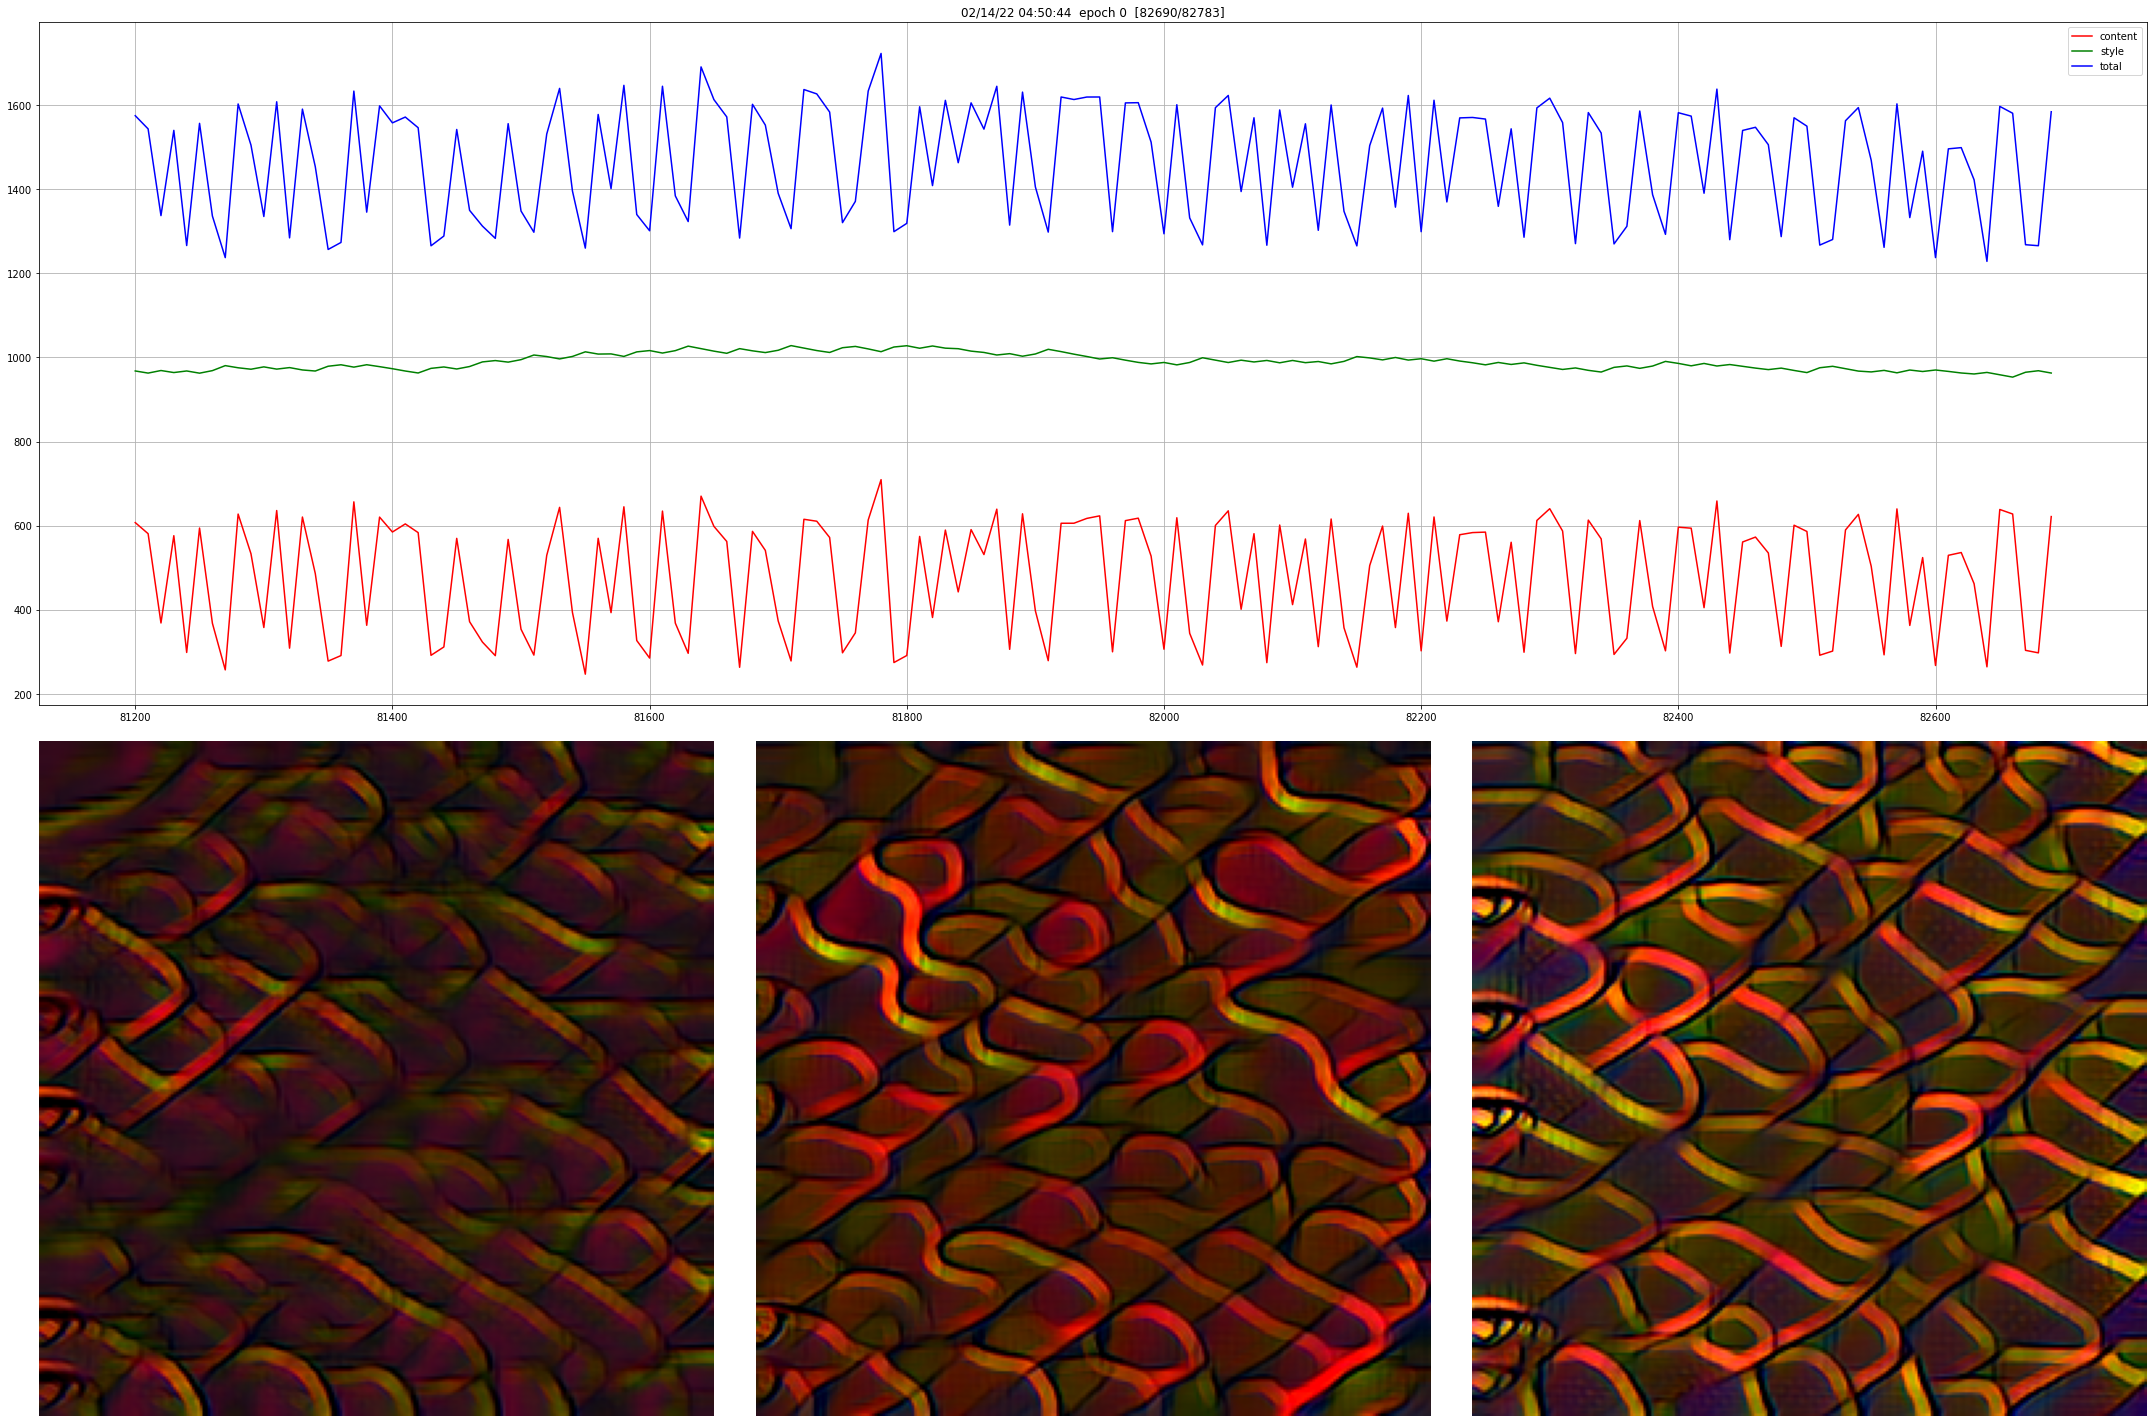

In [ ]:
train(args) 

In [9]:
def stylize_onnx_caffe2(content_image, args):
    """
    Read ONNX model and run it using Caffe2
    """

    assert not args.export_onnx

    import onnx
    import onnx_caffe2.backend

    model = onnx.load(args.model)

    prepared_backend = onnx_caffe2.backend.prepare(model, device='CUDA' if args.cuda else 'CPU')
    inp = {model.graph.input[0].name: content_image.numpy()}
    c2_out = prepared_backend.run(inp)[0]

    return torch.from_numpy(c2_out)


def main():
    main_arg_parser = argparse.ArgumentParser(description="parser for fast-neural-style")
    subparsers = main_arg_parser.add_subparsers(title="subcommands", dest="subcommand")

    train_arg_parser = subparsers.add_parser("train", help="parser for training arguments")
    train_arg_parser.add_argument("--epochs", type=int, default=2,
                                  help="number of training epochs, default is 2")
    train_arg_parser.add_argument("--batch-size", type=int, default=4,
                                  help="batch size for training, default is 4")
    train_arg_parser.add_argument("--dataset", type=str, required=True,
                                  help="path to training dataset, the path should point to a folder "
                                       "containing another folder with all the training images")
    train_arg_parser.add_argument("--style-image", type=str, default="images/style-images/mosaic.jpg",
                                  help="path to style-image")
    train_arg_parser.add_argument("--save-model-dir", type=str, required=True,
                                  help="path to folder where trained model will be saved.")
    train_arg_parser.add_argument("--checkpoint-model-dir", type=str, default=None,
                                  help="path to folder where checkpoints of trained models will be saved")
    train_arg_parser.add_argument("--image-size", type=int, default=256,
                                  help="size of training images, default is 256 X 256")
    train_arg_parser.add_argument("--style-size", type=int, default=None,
                                  help="size of style-image, default is the original size of style image")
    train_arg_parser.add_argument("--cuda", type=int, required=True,
                                  help="set it to 1 for running on GPU, 0 for CPU")
    train_arg_parser.add_argument("--seed", type=int, default=42,
                                  help="random seed for training")
    train_arg_parser.add_argument("--content-weight", type=float, default=1e5,
                                  help="weight for content-loss, default is 1e5")
    train_arg_parser.add_argument("--style-weight", type=float, default=1e10,
                                  help="weight for style-loss, default is 1e10")
    train_arg_parser.add_argument("--lr", type=float, default=1e-3,
                                  help="learning rate, default is 1e-3")
    train_arg_parser.add_argument("--log-interval", type=int, default=500,
                                  help="number of images after which the training loss is logged, default is 500")
    train_arg_parser.add_argument("--checkpoint-interval", type=int, default=2000,
                                  help="number of batches after which a checkpoint of the trained model will be created")
    train_arg_parser.add_argument("--model", type=str, default=None, help="saved model")

    eval_arg_parser = subparsers.add_parser("eval", help="parser for evaluation/stylizing arguments")
    eval_arg_parser.add_argument("--content-image", type=str, required=True,
                                 help="path to content image you want to stylize")
    eval_arg_parser.add_argument("--content-scale", type=float, default=None,
                                 help="factor for scaling down the content image")
    eval_arg_parser.add_argument("--output-image", type=str, required=True,
                                 help="path for saving the output image")
    eval_arg_parser.add_argument("--model", type=str, required=True,
                                 help="saved model to be used for stylizing the image. If file ends in .pth - PyTorch path is used, if in .onnx - Caffe2 path")
    eval_arg_parser.add_argument("--animate", type=int, default=0,
                                 help="set it to 1 to export an animated set of frames, 0 for single frame export")
    eval_arg_parser.add_argument("--cuda", type=int, required=True,
                                 help="set it to 1 for running on GPU, 0 for CPU")
    eval_arg_parser.add_argument("--export_onnx", type=str,
                                 help="export ONNX model to a given file")

    args = main_arg_parser.parse_args()

    if args.subcommand is None:
        print("ERROR: specify either train or eval")
        sys.exit(1)
    if args.cuda and not torch.cuda.is_available():
        print("ERROR: cuda is not available, try running on CPU")
        sys.exit(1)

    if args.subcommand == "train":
        check_paths(args)
        train(args)
    else:
        stylize(args)

In [10]:
def stylize(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    if args.model.endswith(".onnx"):
        output = stylize_onnx_caffe2(content_image, args)
    else:
        with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load(args.model)
            # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to(device)

            conditioner = ConditionerNet()
            csd = torch.load(args.model+'.cond.pth')
            conditioner.load_state_dict(csd)
            conditioner.to(device)

            if args.export_onnx:
                assert args.export_onnx.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(style_model, content_image, args.export_onnx).cpu()
            else:
                if args.animate:
                    keypoints = [
                        torch.tensor([0., 0, 1, 0]),
                        torch.tensor([0., 1, 0, 1]),
                        torch.tensor([1., 0, 0, 0]),
                        torch.tensor([1., 1, 1, 1]),
                        torch.tensor([0., 0, 0, 0]),
                        torch.tensor([0., 0, 0, 1]),
                    ]

                    for frame in range(0, 750):
                        start = frame // 150
                        end = start + 1

                        stylization_vector = keypoints[start].lerp(keypoints[end], (frame % 150) / 150).to(device)

                        c_values = conditioner(
                            stylization_vector.unsqueeze(0).unsqueeze(2).unsqueeze(2))

                        gammas = c_values[:, 0:2112, :, :]
                        betas = c_values[:, 2112:4224, :, :]  

                        output = style_model(content_image, gammas, betas).cpu()
                        save_image(args.output_image + "." + str(frame) + ".jpg", output[0])
                else:
                    stylization_vector = torch.tensor([1., 1, 1, 1]).to(device)

                    c_values = conditioner(
                        stylization_vector.unsqueeze(0).unsqueeze(2).unsqueeze(2))

                    gammas = c_values[:, 0:2112, :, :]
                    betas = c_values[:, 2112:4224, :, :]  

                    output = style_model(content_image, gammas, betas).cpu()
    save_image(args.output_image, output[0])

In [13]:
class Arguments:
    pass

args=Arguments()
args.cuda = True
args.learning_rate = 1e-3
args.model = '/content/drive/MyDrive/cmc/stylization/style_transfer_checkpoints/epoch_1_Sun_Feb_13_00_14_38_2022_10.0_500000.0.model'
args.models_dir = 'Models/'
args.model_name = 'diff_styles'   # trained model saved to args.save_model_dir+args.model_name+'.pth'. Also args.model_name affects name of checkpoint models. 
args.exp_weight = 0.01  # how much to exponentially average content and style loss time series
args.dataset = '/content/drive/MyDrive/cmc/stylization/MS_COCO' # take from https://cocodataset.org/#download. Any dataset of photo images works.
args.style_image = '/content/drive/MyDrive/cmc/stylization/styles/african_art.jpg'  # path to style-images directory (holding images of styles)
args.content_image = '/content/drive/MyDrive/cmc/stylization/content_variants/1.jpg'
args.init_transformer_model = '' #Models/current4/checkpoint_images_100000/transformer.model #'Models/Save/my_model_orig.pth'
args.init_style_models_dir = '' #'/store/Datasets/Sample_Styles/'  # path to style-images directory (holding images of styles)
args.batch_size = 10   # take more, if GPU memory permits
args.epochs = 1       # number of training epochs (training over 20.000 images is enough for convergence)
args.style_size = 256  # size of style-image, default is the original size of style image
args.image_size = 256 #496  # size of training images, default is 256 X 256
args.seed = 42         # random seed for training
args.lr = 1e-3         # learning rate for optimizer
args.content_weight = 1e1  
args.style_weight = 1e6/2     
args.log_interval = 10    # number of batches after which the training loss is logged
args.checkpoint_interval = 1000   # set to None for no checkpoints. number of batches after which a checkpoint of the trained model will be created
args.style_div = 3  # by how much to divide H and W to reproduce larger style patches
args.save_dir = '/content/drive/MyDrive/cmc/stylization/african_checkpoints'


args.content_scale = 6

args.export_onnx = False
args.output_image = '/content/drive/MyDrive/cmc/stylization/output/pic.jpg'
args.animate = False

In [14]:
stylize(args)

In [ ]:
def varying_layers(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    if args.model.endswith(".onnx"):
        output = stylize_onnx_caffe2(content_image, args)
    else:
        with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load(args.model)
            # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to(device)

            conditioner = ConditionerNet()
            csd = torch.load(args.model+'.cond.pth')
            conditioner.load_state_dict(csd)
            conditioner.to(device)

            if args.export_onnx:
                assert args.export_onnx.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(style_model, content_image, args.export_onnx).cpu()
            else:
                vectors = [
                        torch.tensor([0., 0, 0, 0]),
                        torch.tensor([0., 0, 1, 0]),
                        torch.tensor([0., 1, 0, 1]),
                        torch.tensor([1., 0, 0, 0]),
                        torch.tensor([1., 1, 1, 1]),
                        torch.tensor([0., 0, 0, 0]),
                        torch.tensor([0., 0, 0, 1]),
                    ]

                for i in range(len(vectors)):
                    stylization_vector = vectors[i].to(device)

                    c_values = conditioner(
                        stylization_vector.unsqueeze(0).unsqueeze(2).unsqueeze(2))

                    gammas = c_values[:, 0:2112, :, :]
                    betas = c_values[:, 2112:4224, :, :]  

                    output = style_model(content_image, gammas, betas).cpu()
                    save_image(args.output_image + "." + str(i) + ".jpg", output[0])

In [ ]:
varying_layers(args)